In [1]:
from aeon.datasets import load_classification
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/gilberto/projects/defconv_time_series')

import warnings
warnings.filterwarnings('ignore')

import torch

from src.models import FCN, DeformableFCN
from src.utils import load_data, to_torch_dataset, to_torch_loader
from lightning.pytorch import seed_everything
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint
import numpy as np

### Analysis for fixed kernel grid on FCN

In [2]:
X_train, y_train, X_test, y_test = load_data(name='CinCECGTorso', task='classification', split='full')
train_set, test_set = to_torch_dataset(X_train, y_train, X_test, y_test)
train_loader, test_loader = to_torch_loader(train_dataset=train_set, test_dataset=test_set)

In [3]:
num_classes = len(np.unique(y_train))
model = FCN(in_dim=1, num_classes=num_classes)

checkpoint = ModelCheckpoint(
    monitor='train_loss',
    filename=f'fcn-ArrowHead',
    save_top_k=1,
    auto_insert_metric_name=False
)

trainer = Trainer(
    max_epochs=1000,
    accelerator='gpu',
    callbacks=[checkpoint],
)

trainer.fit(model, train_dataloaders=train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params
-------------------------------------------------
0 | conv_layers | Sequential       | 264 K 
1 | linear      | Linear           | 516   
2 | criteria    | CrossEntropyLoss | 0     
-------------------------------------------------
265 K     Trainable params
0         Non-trainable params
265 K     Total params
1.061     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


In [4]:
results = trainer.test(dataloaders=test_loader, ckpt_path='best')

Restoring states from the checkpoint path at /home/gilberto/projects/defconv_time_series/notebooks/lightning_logs/version_17/checkpoints/fcn-ArrowHead.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/gilberto/projects/defconv_time_series/notebooks/lightning_logs/version_17/checkpoints/fcn-ArrowHead.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           acc              0.8384057879447937
           f1               0.8178094625473022
        precision            0.844315767288208
         recall              0.837483286857605
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [5]:
model.eval()

with torch.no_grad():
    
    sample, _ = train_set[:1]
    
    # Passing through the layers and saving the feature maps
    conv_1_result = model.conv_layers[0](sample)
    bn_1_result = model.conv_layers[1](conv_1_result)
    relu_1_result = model.conv_layers[2](bn_1_result)
    
    conv_2_result = model.conv_layers[3](relu_1_result)
    bn_2_result = model.conv_layers[4](conv_2_result)
    relu_2_result = model.conv_layers[5](bn_2_result)
    
    conv_3_result = model.conv_layers[6](relu_2_result)
    bn_3_result = model.conv_layers[7](conv_3_result)
    relu_3_result = model.conv_layers[8](bn_3_result)

### Analysis for sparsed kernel grid on DefFCN

In [42]:
num_classes = len(np.unique(y_train))
model_2 = DeformableFCN(in_dim=1, num_classes=num_classes)

checkpoint = ModelCheckpoint(
    monitor='train_loss',
    filename=f'fcn-BeetleFly',
    save_top_k=1,
    auto_insert_metric_name=False
)

trainer_2 = Trainer(
    max_epochs=1000,
    accelerator='gpu',
    callbacks=[checkpoint],
)

trainer_2.fit(model_2, train_dataloaders=train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params
-------------------------------------------------
0 | conv_layers | Sequential       | 381 K 
1 | linear      | Linear           | 516   
2 | criteria    | CrossEntropyLoss | 0     
-------------------------------------------------
382 K     Trainable params
0         Non-trainable params
382 K     Total params
1.530     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


In [8]:
results = trainer_2.test(dataloaders=test_loader, ckpt_path='best')

Restoring states from the checkpoint path at /home/gilberto/projects/defconv_time_series/notebooks/lightning_logs/version_16/checkpoints/fcn-BeetleFly.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/gilberto/projects/defconv_time_series/notebooks/lightning_logs/version_16/checkpoints/fcn-BeetleFly.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           acc              0.8202898502349854
           f1                0.798865795135498
        precision           0.8237543702125549
         recall             0.8213652968406677
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [9]:
model_2

DeformableFCN(
  (conv_layers): Sequential(
    (0): Conv1d(1, 128, kernel_size=(8,), stride=(1,), padding=same)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=same)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): PackedDeformableConvolution1d(
      256, 128, kernel_size=5, stride=1, padding = same, dilation=1, bias=False, padding_mode=reflect
      (offset_dconv): Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=same, groups=256, bias=False, padding_mode=reflect)
      (offset_dconv_prelu): PReLU(num_parameters=1)
      (offset_pconv): Conv1d(256, 5, kernel_size=(1,), stride=(1,), bias=False)
      (offset_pconv_prelu): PReLU(num_parameters=1)
    )
    (7): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=same)
    (8): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_r

In [24]:
model_2.eval()

with torch.no_grad():    
    sample, _ = train_set[:10]
    
    # Passing through the layers and saving the feature maps
    conv_1_result_m2 = model_2.conv_layers[0](sample)
    bn_1_result_m2 = model_2.conv_layers[1](conv_1_result_m2)
    relu_1_result_m2 = model_2.conv_layers[2](bn_1_result_m2)
    
    conv_2_result_m2 = model_2.conv_layers[3](relu_1_result_m2)
    bn_2_result_m2 = model_2.conv_layers[4](conv_2_result_m2)
    relu_2_result_m2 = model_2.conv_layers[5](bn_2_result_m2)
    
    offset_dconv = model_2.conv_layers[6].offset_dconv(relu_2_result_m2)
    offset_dconv_prelu = model_2.conv_layers[6].offset_dconv_prelu(offset_dconv)
    
    offset_pconv = model_2.conv_layers[6].offset_pconv(offset_dconv_prelu)
    offset_pconv_prelu = model_2.conv_layers[6].offset_pconv_prelu(offset_pconv)
    
    offsets = offset_pconv_prelu.unsqueeze(0).chunk(1, dim=2)
    offsets = torch.vstack(offsets)

In [27]:
offsets[0, 0, 0, 109:112] # Sparsed kernel values

tensor([190.7815, 192.6115, 199.6577])

In [40]:
offsets[0, 0, 0, 109:112].max()

tensor(199.6577)

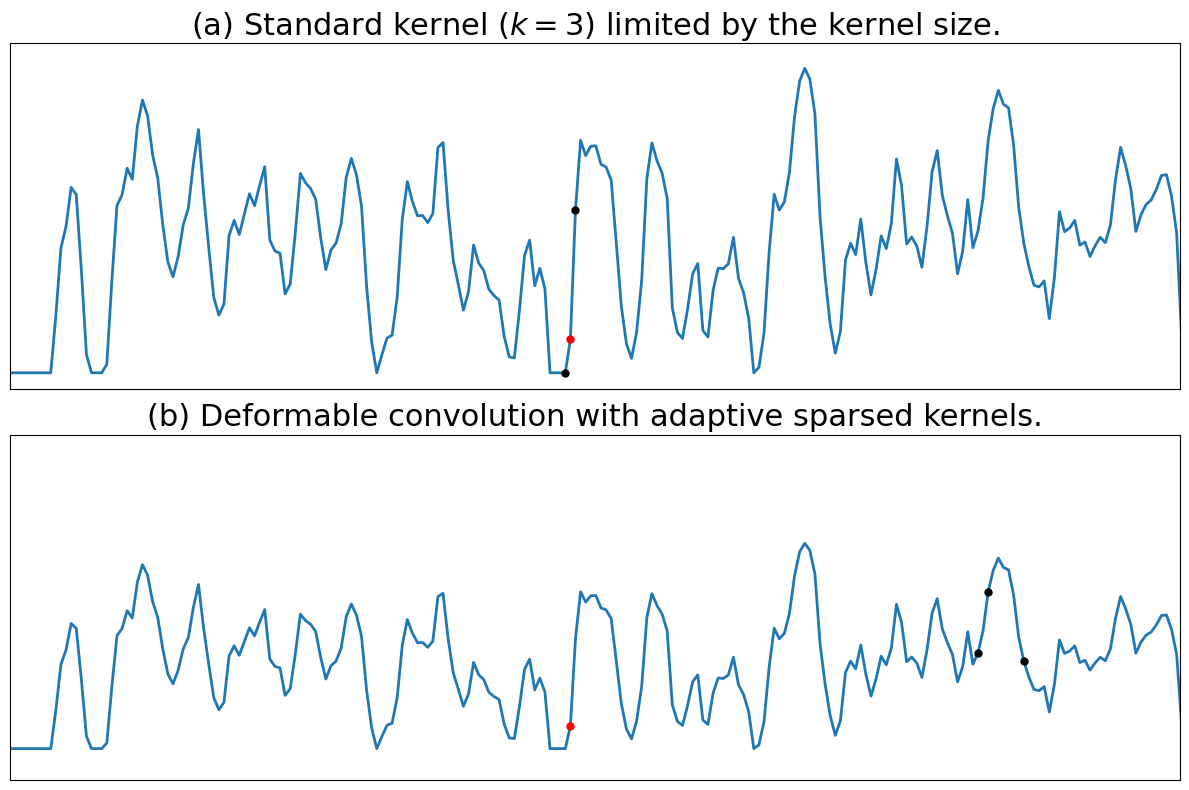

In [44]:
# To easilly illustrate the examples due to the size of the series we take some observations by hand on the series. Note that this does not
# impact the analysis here, we only want to demonstrate how the different kernels works. This isn't a performance or result analysis, only
# a demonstration for the fixed and sparsed kernel grids.

fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(12, 8))

axs[0].plot(relu_2_result.numpy()[0,0,:], linewidth=2)

axs[0].plot(110, relu_2_result.numpy()[0,0,110], color='red', marker='o', markersize=5)
axs[0].plot(109, relu_2_result.numpy()[0,0,109], color='black', marker='o', markersize=5)
axs[0].plot(111, relu_2_result.numpy()[0,0,111], color='black', marker='o', markersize=5)

# axs[0].axvspan(109, 111, alpha=0.5, color='red', label='kernel grid')

axs[0].set_xlim([0, offsets[0, 0, 0, 109:112].max().item() + 30])

axs[0].tick_params(left = False, right = False ,labelleft = False, labelbottom = False, bottom = False) 
axs[0].set_title(r'(a) Standard kernel ($k=3$) limited by the kernel size.', fontsize=22)

# axs[0].legend()

axs[1].plot(relu_2_result.numpy()[0,0,:], linewidth=2)

axs[1].plot(110, relu_2_result.numpy()[0,0,110], color='red', marker='o', markersize=5)

axs[1].plot(offsets[0, 0, 0, 109:112][0].floor(), relu_2_result.numpy()[0,0,offsets[0, 0, 0, 109:112][0].floor().int().item()], color='black', marker='o', markersize=5)
axs[1].plot(offsets[0, 0, 0, 109:112][1].floor(), relu_2_result.numpy()[0,0,offsets[0, 0, 0, 109:112][1].floor().int().item()], color='black', marker='o', markersize=5)
axs[1].plot(offsets[0, 0, 0, 109:112][2].floor(), relu_2_result.numpy()[0,0,offsets[0, 0, 0, 109:112][2].floor().int().item()], color='black', marker='o', markersize=5)

# We just use the .5 to make the retangle a little bit better to visualize
# axs[1].axvspan(362.5, 363.5, alpha=0.5, color='red', label='kernel grid')
# axs[1].axvspan(346.5, 347.5, alpha=0.5, color='red')
# axs[1].axvspan(337.5, 338.5, alpha=0.5, color='red')

axs[1].set_ylim([-0.1, 1])
axs[1].set_xlim([0, offsets[0, 0, 0, 109:112].max().item() + 30])

axs[1].tick_params(left = False, right = False ,labelleft = False, labelbottom = False, bottom = False) 
axs[1].set_title('(b) Deformable convolution with adaptive sparsed kernels.', fontsize=22)

# axs[1].legend()

plt.tight_layout()
plt.savefig('comparison_kernel_grids.pdf')

KeyboardInterrupt: 

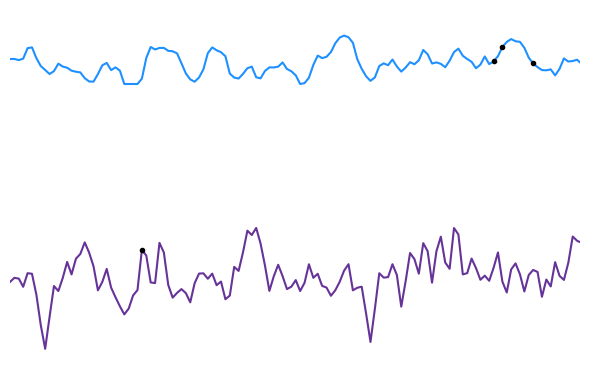

In [132]:
plt.figure(figsize=(6, 4))

deformable_conv_result = model_2.conv_layers[6](relu_2_result_m2)

plt.plot(list(range(relu_2_result.shape[-1])), relu_2_result[0, 0, :].detach().numpy() + 3, color='dodgerblue')
plt.plot(list(range(conv_2_result_m2.shape[-1])), deformable_conv_result[0, 0, :].detach().numpy(), color='rebeccapurple')

# plt.plot(
#     list(range(110 + int((offsets[0,0,0, 109:112].max().floor().int().item() - 110) / 2),
#                110 + int((offsets[0,0,0, 109:112].max().floor().int().item() - 110) / 2) + 3, 1)), 
#     model_2.conv_layers[6].weight[0, 0, :3].detach().numpy() + 2
# )

# # Draw lines
# plt.plot((offsets[0, 0, 0, 109:112][0].floor(), 110), (relu_2_result[0, 0, offsets[0, 0, 0, 109:112][0].floor().int().item()] + 3, deformable_conv_result[0, 0, 110].detach().numpy()), color='firebrick', linestyle='--')
# plt.plot((offsets[0, 0, 0, 109:112][1].floor(), 110), (relu_2_result[0, 0, offsets[0, 0, 0, 109:112][1].floor().int().item()] + 3, deformable_conv_result[0, 0, 110].detach().numpy()), color='firebrick', linestyle='--')
# plt.plot((offsets[0, 0, 0, 109:112][2].floor(), 110), (relu_2_result[0, 0, offsets[0, 0, 0, 109:112][2].floor().int().item()] + 3, deformable_conv_result[0, 0, 110].detach().numpy()), color='firebrick', linestyle='--')

# # Draw points
plt.plot(offsets[0, 0, 0, 109:112][0].floor(), relu_2_result[0, 0, offsets[0, 0, 0, 109:112][0].floor().int().item()] + 3, marker='o', color='black', markersize=3)
plt.plot(offsets[0, 0, 0, 109:112][1].floor(), relu_2_result[0, 0, offsets[0, 0, 0, 109:112][1].floor().int().item()] + 3, marker='o', color='black', markersize=3)
plt.plot(offsets[0, 0, 0, 109:112][2].floor(), relu_2_result[0, 0, offsets[0, 0, 0, 109:112][2].floor().int().item()] + 3, marker='o', color='black', markersize=3)

plt.plot(110, deformable_conv_result[0, 0, 110].detach().numpy(), marker='o', color='black', markersize=3)


plt.ylim([-1, 4])
plt.xlim([80, offsets[0, 0, 0, 109:112].max().item() + 10])

plt.axis('off')
plt.tight_layout()

plt.savefig('deformable_convolution.pdf')

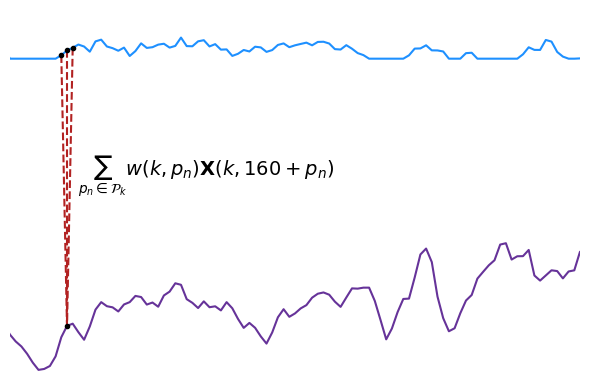

In [41]:
plt.figure(figsize=(6, 4))

plt.plot(list(range(relu_2_result.shape[-1])), relu_2_result[0, 0, :].detach().numpy() + 3, color='dodgerblue')
plt.plot(list(range(relu_2_result.shape[-1])), conv_3_result[0, 0, :].detach().numpy(), color='rebeccapurple')

# plt.plot(
#     list(range(110 + int((offsets[0,0,0, 109:112].max().floor().int().item() - 110) / 2),
#                110 + int((offsets[0,0,0, 109:112].max().floor().int().item() - 110) / 2) + 3, 1)), 
#     model_2.conv_layers[6].weight[0, 0, :3].detach().numpy() + 2
# )

# # Draw lines
plt.plot((159, 160), (relu_2_result[0, 0, 159] + 3, conv_3_result[0, 0, 160].detach().numpy()), color='firebrick', linestyle='--')
plt.plot((160, 160), (relu_2_result[0, 0, 160] + 3, conv_3_result[0, 0, 160].detach().numpy()), color='firebrick', linestyle='--')
plt.plot((161, 160), (relu_2_result[0, 0, 161] + 3, conv_3_result[0, 0, 160].detach().numpy()), color='firebrick', linestyle='--')

# # Draw points
plt.plot(159, relu_2_result[0, 0, 159] + 3, marker='o', color='black', markersize=3)
plt.plot(160, relu_2_result[0, 0, 160] + 3, marker='o', color='black', markersize=3)
plt.plot(161, relu_2_result[0, 0, 161] + 3, marker='o', color='black', markersize=3)

plt.plot(160, conv_3_result[0, 0, 160].detach().numpy(), marker='o', color='black', markersize=3)


plt.ylim([-0.3, 3.5])
plt.xlim([150, 250])

plt.text(162, 1.8, r'$\sum_{p_n \in \mathcal{P}_k} w(k, p_n) \mathbf{X}(k, 160 + p_n)$', fontsize=14)

plt.axis('off')
plt.tight_layout()

plt.savefig('standard_convolution.pdf')